# Secured Telemetry by Time-Variant Sensing Matrix

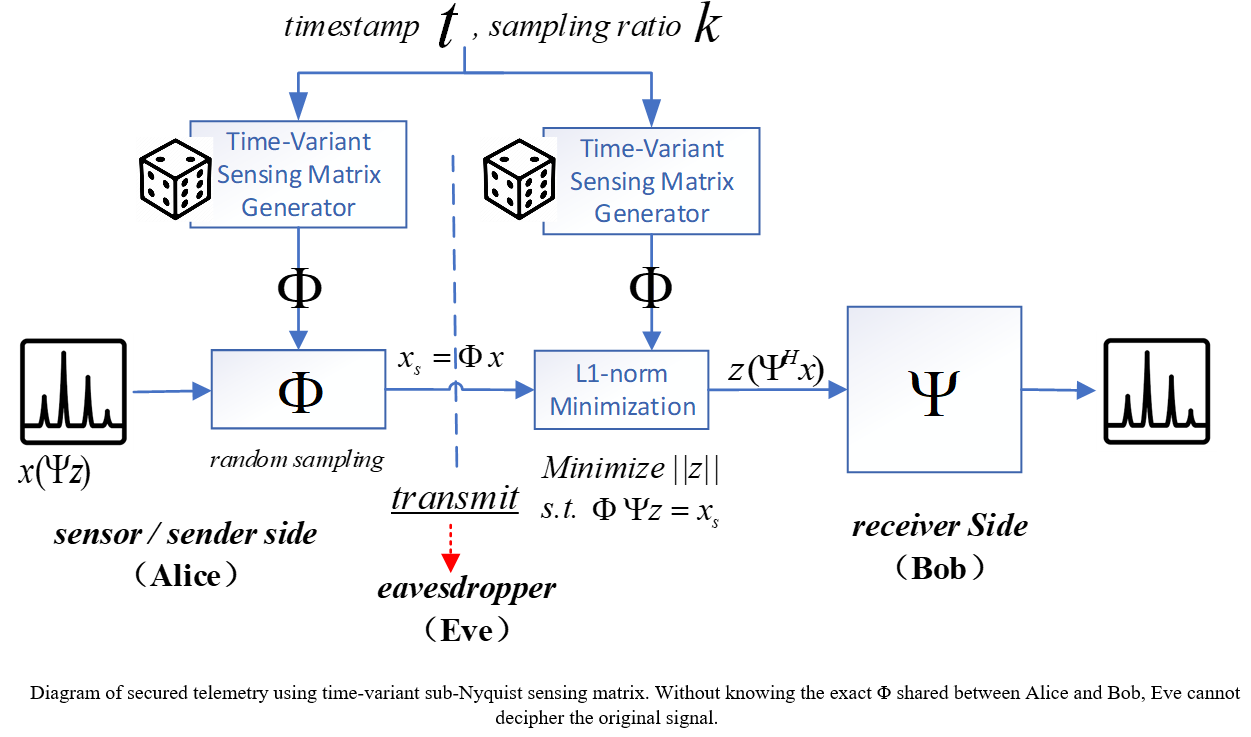

# Install 

This code uses our 'cs1' package (https://github.com/zhangys11/cs1)   

```pip install cs1```

You also need to install our 'qsi-tk' package to use the data I/O functions,  

```pip install qsi-tk```

# Load Data

load dataset from 734b.csv
X.shape (15, 2090)


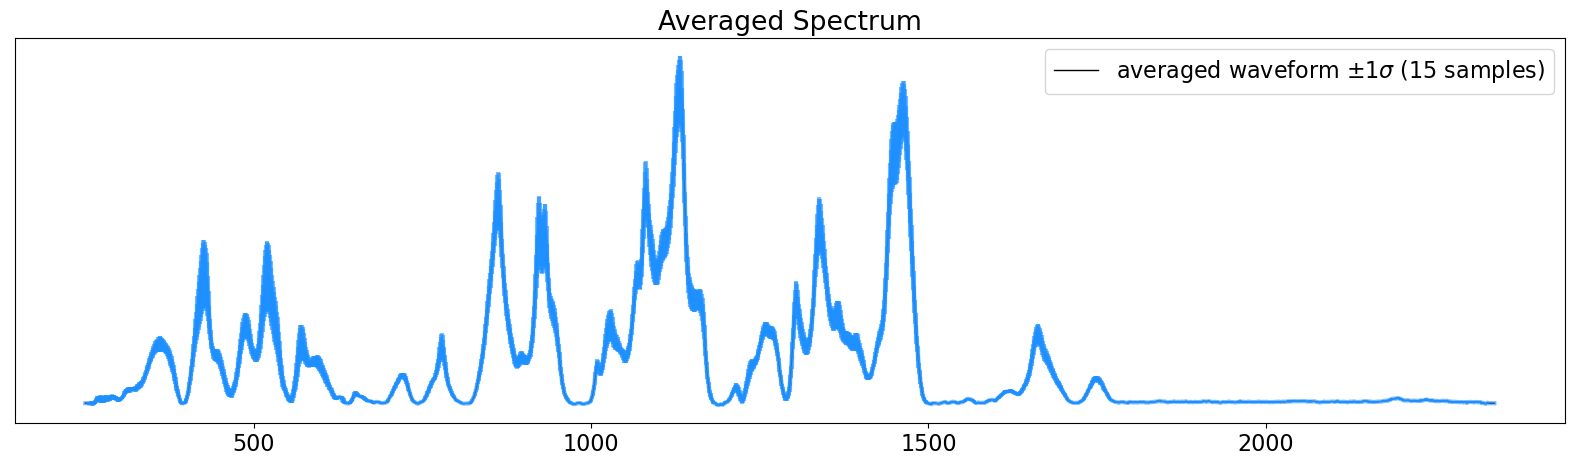

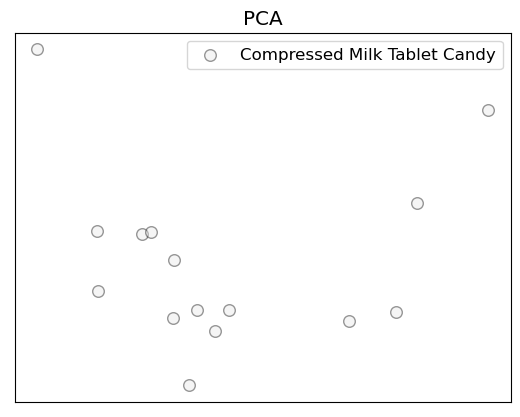

Column Meanings: Raman shift / wavenumber (cm-1). Range: 250~2339
Each row is one sample. 
Total 15 sampless

  X meaning: drift time
  X range: 0 ~ 31 ms
  Resolution: 0.02 ms / 20 us

* Data Source: Compressed Milk Tablet Candy, with Calcium and Vitamin A,D additives
* Source: Heilongjiang Province, China.
-------------------------
Internal Source ID 734b
Edit date: Jan 13, 2020


In [1]:
from qsi import io
X, y, X_names, _, labels = io.load_dataset('milk_tablet_candy')

## Core Compressed Sensing (CS) Process**

Sampling  
$ x_s = \Phi x $

Sparsity hypothesis  
$ x = \Psi z $

Compressed Sensing / sub-Nyquist Sampling   
$ x_s = \Phi \Psi z $

Reconstruction of latent z    
$ minimize \quad  ||z||_1 \quad s.t. \quad     x_s = \Phi \Psi z $

Inverse-transform to orginal space    
$ x = \Psi z $

## Generating Sensing Matrix

(-0.5, 2089.5, 417.5, -0.5)

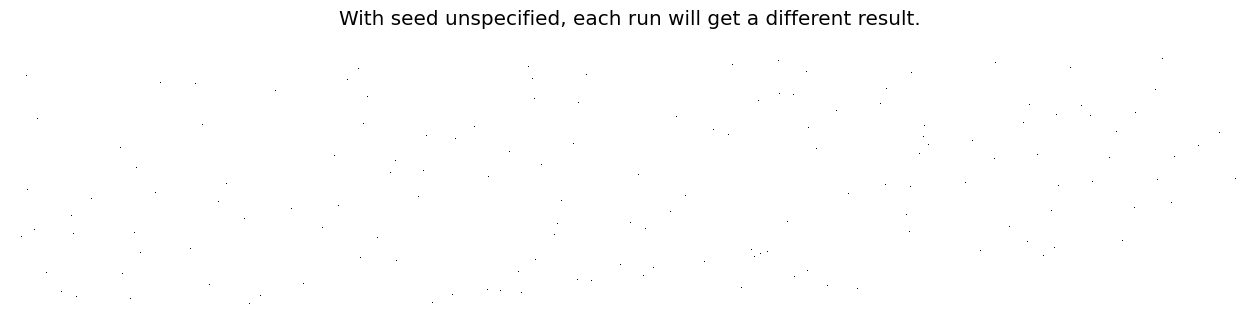

In [2]:
from cs1 import cs
import matplotlib.pyplot as plt
from matplotlib import cm

m,n = X.shape
PHI, OMEGA = cs.GetSensingMatrix(n, k = 0.2, s = None)

# plt.figure(figsize = (12,3))
plt.matshow(PHI, interpolation='nearest', cmap=cm.Greys)
plt.title('With seed unspecified, each run will get a different result.')
plt.axis('off')

### Conversion between timestamp and seed (integer)

Unix and POSIX measure time as the number of seconds that have passed since 1 January 1970 00:00:00 UT, a point in time known as the Unix epoch. The NT time epoch on Windows NT and later refers to the Windows NT system time in (10^-7)s intervals from 0h 1 January 1601.

In [3]:
import cs1.security.tvsm

s = cs1.security.tvsm.Time2Seed()
print(s)

1685766792


In [4]:
cs1.security.tvsm.Seed2Time(s)

'Sat Jun  3 12:33:12 2023'

# Perform CS sensing and reconstruction on the entire dataset

For details of CS, refer to [Compressed Sening.ipynb]

In [20]:
# Load PSIs back from pickle. The pickle is created by cs.Generate_PSIs().
import pickle

m, n = X.shape
file = open('PSIs_' + str(n) + '.pkl','rb')
PSIs = pickle.load(file)
file.close()

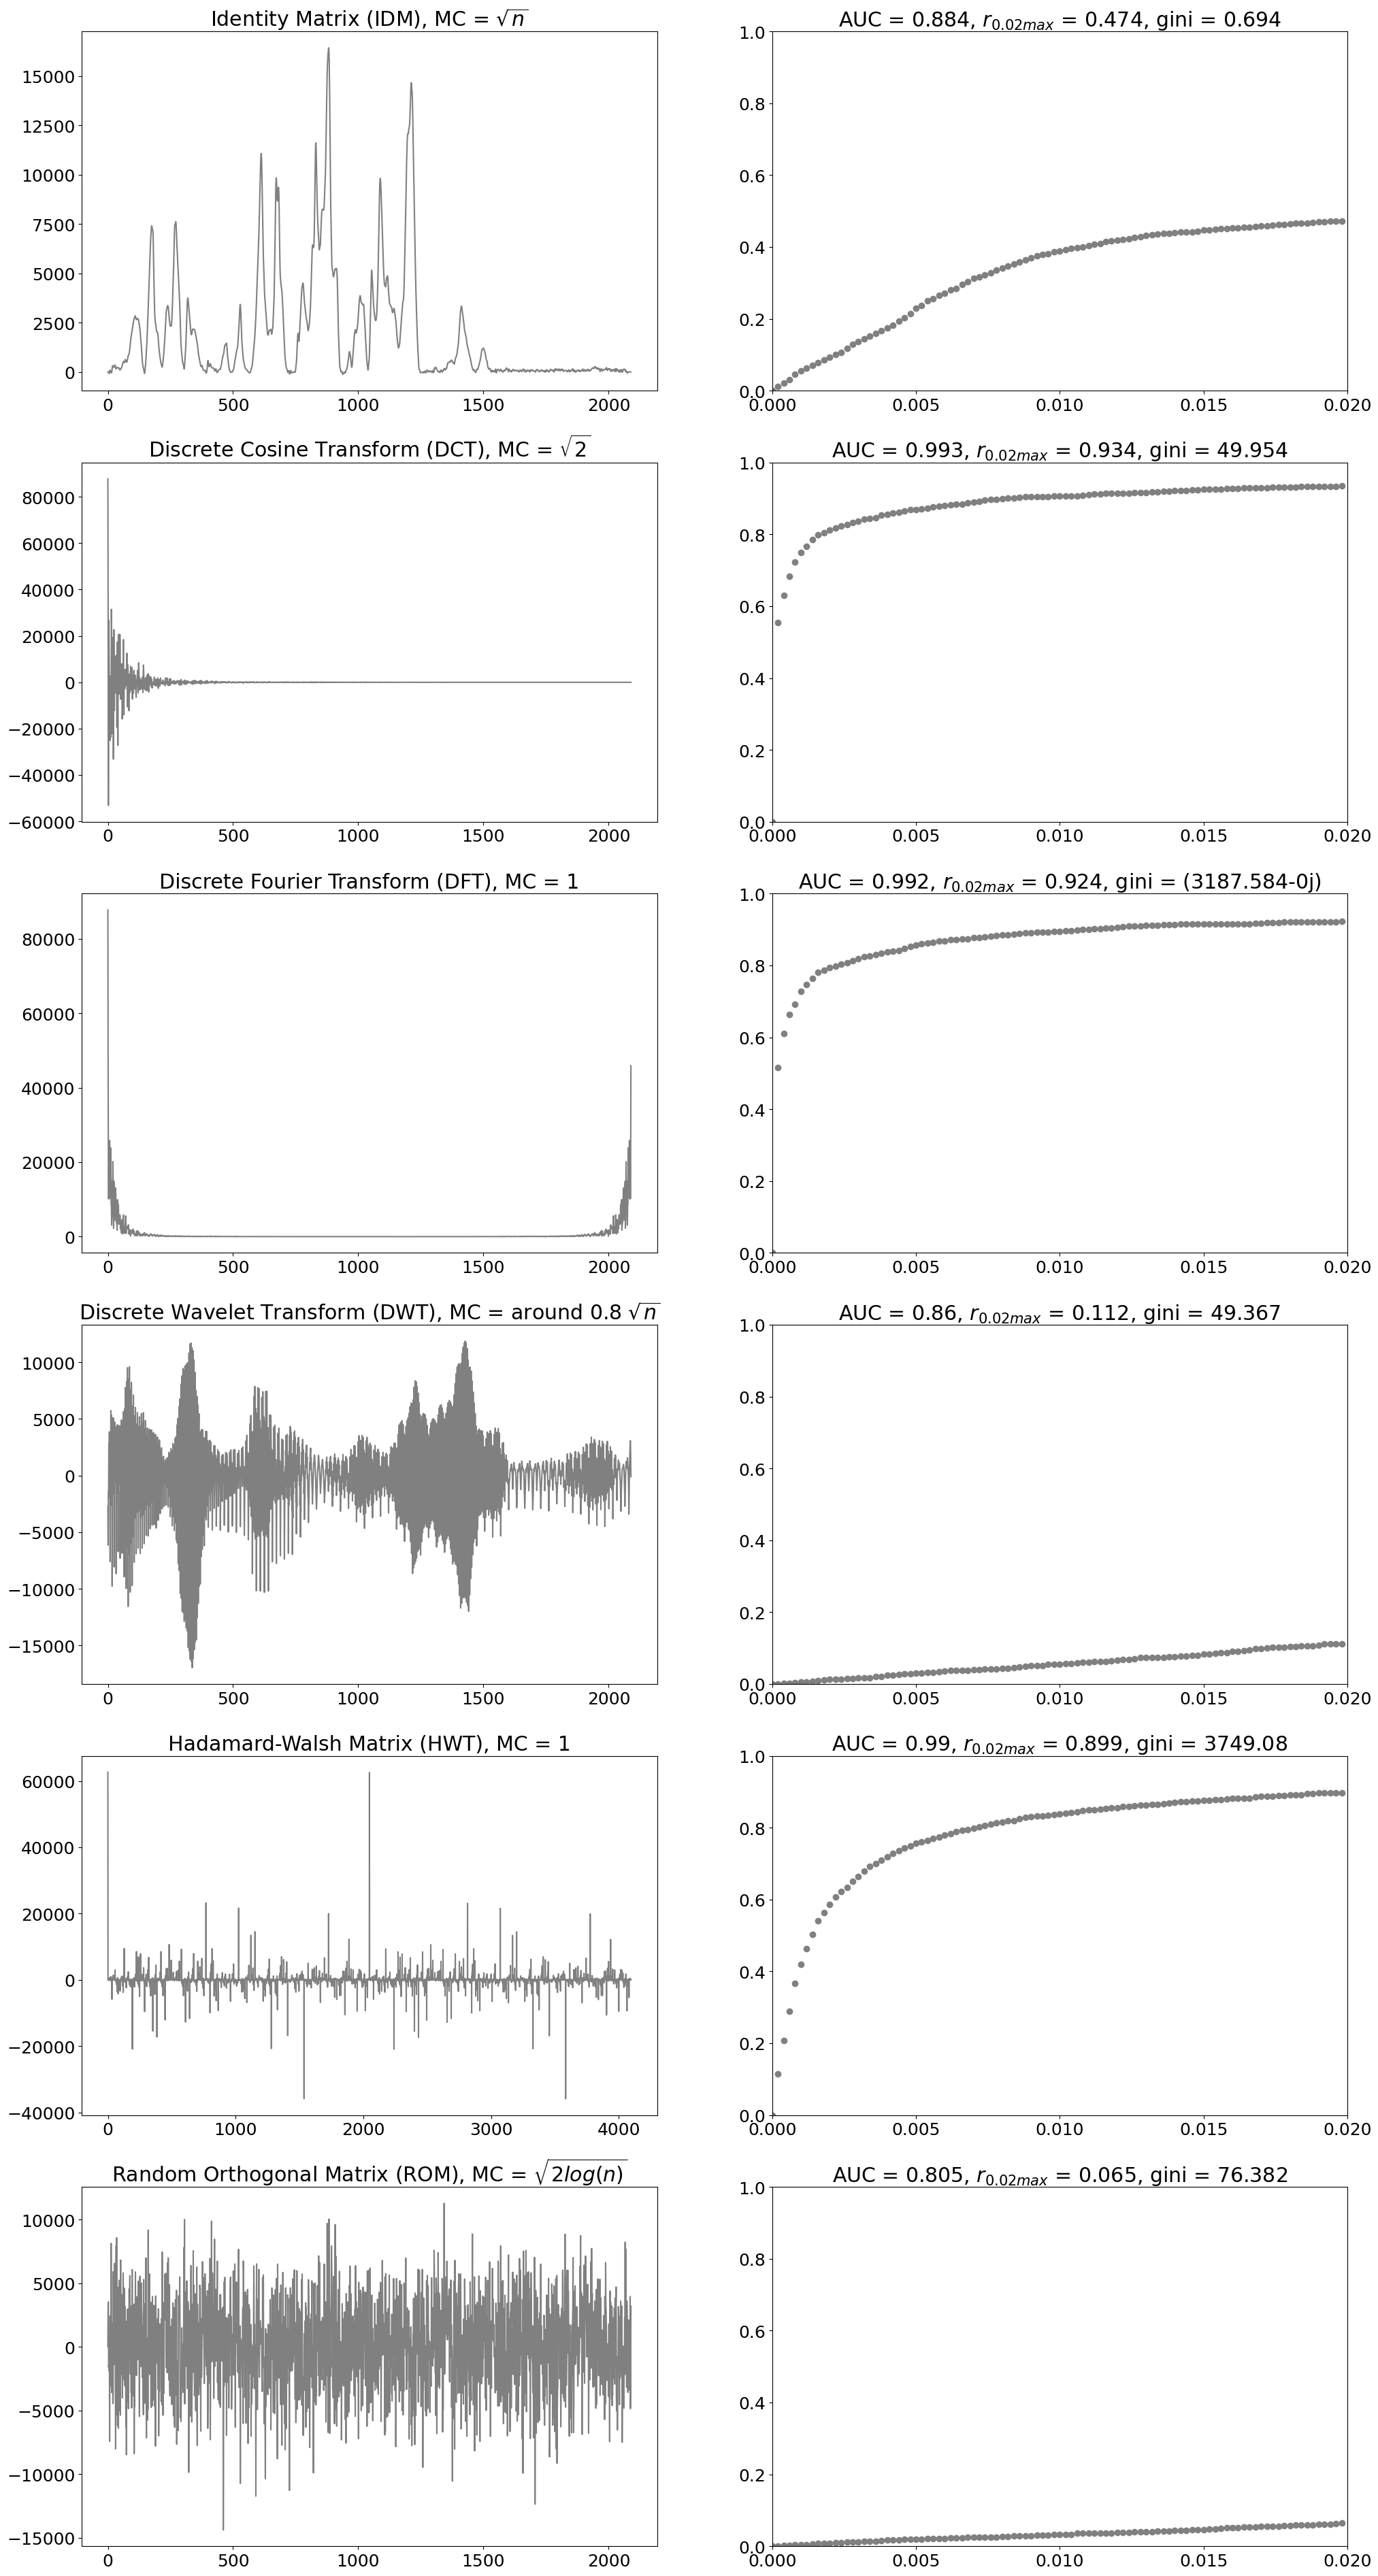

In [6]:
import cs1.metrics
cs1.metrics.analyze_sparsity(X[0], PSIs)

## Visualize all samples



===== Ψ = IDM, k =0.1 ======

Sample 1


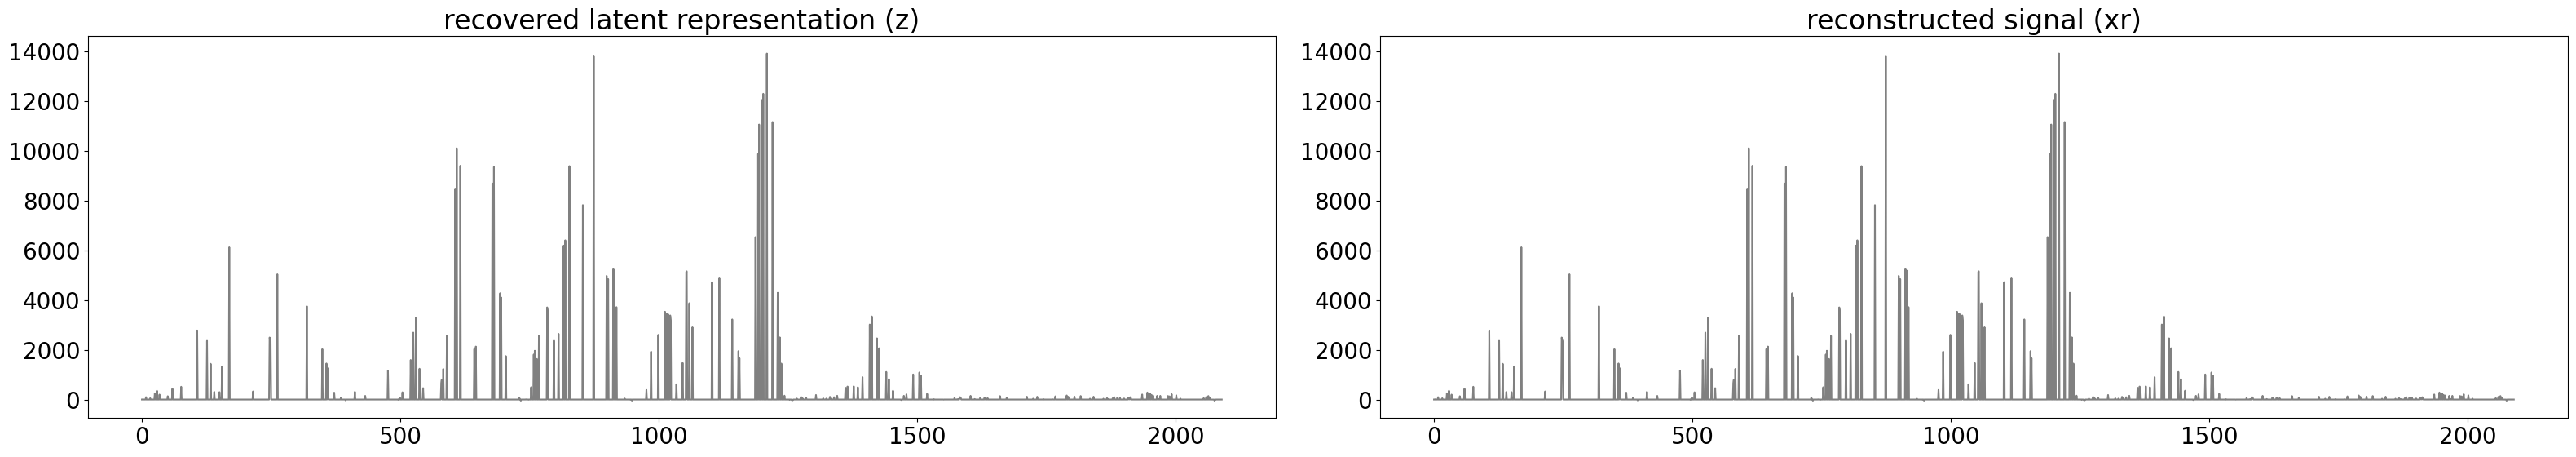

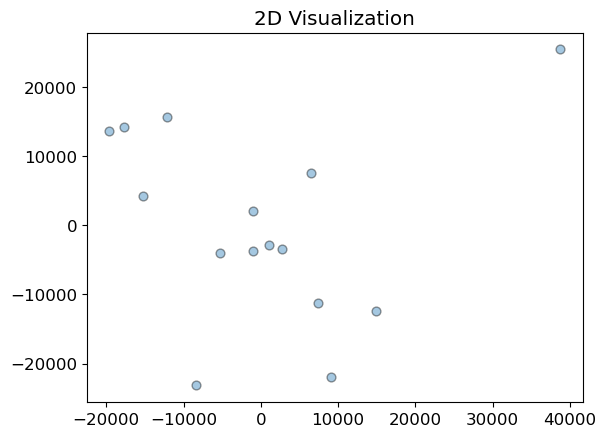



===== Ψ = IDM, k =0.5 ======

Sample 1


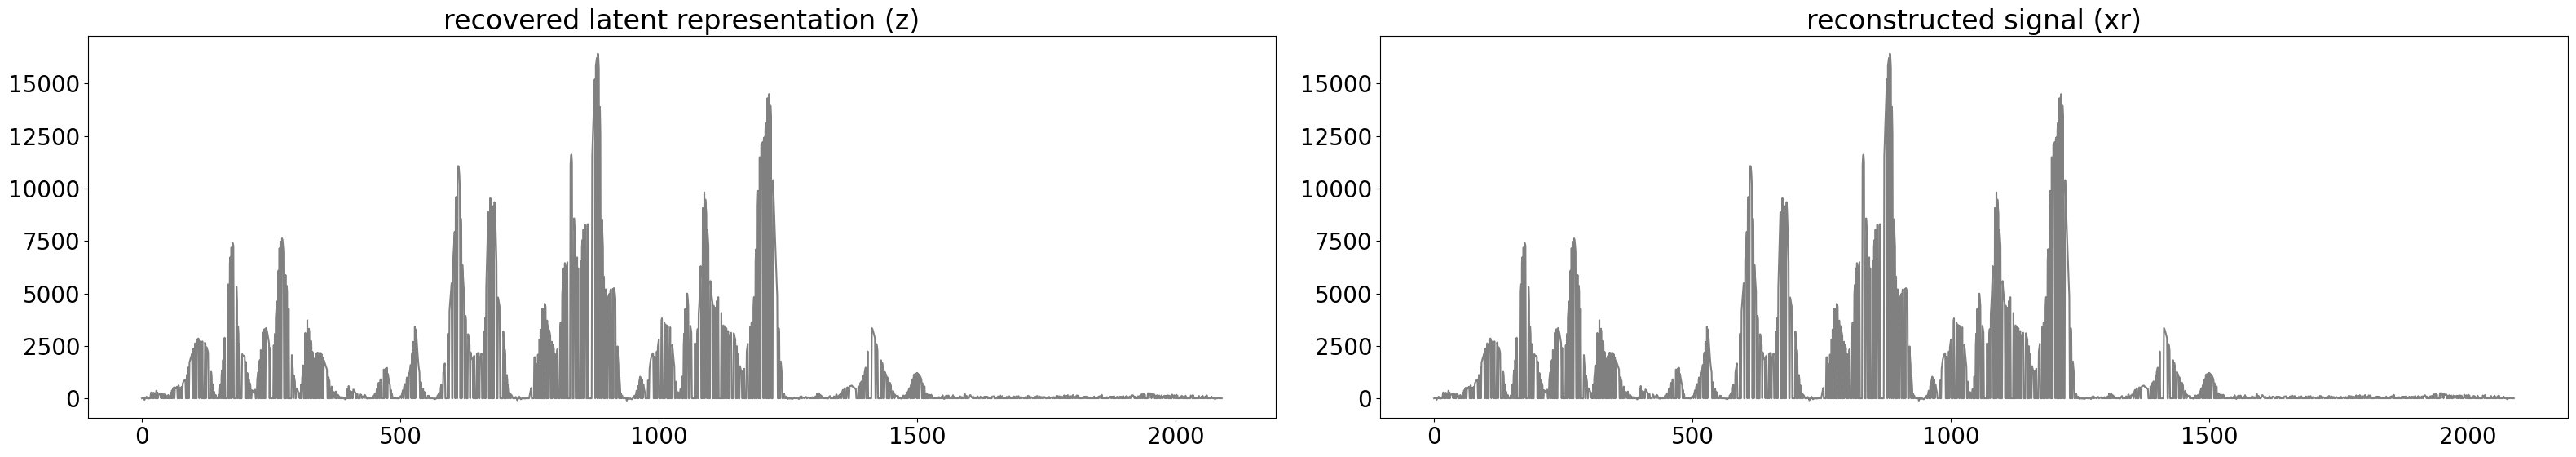

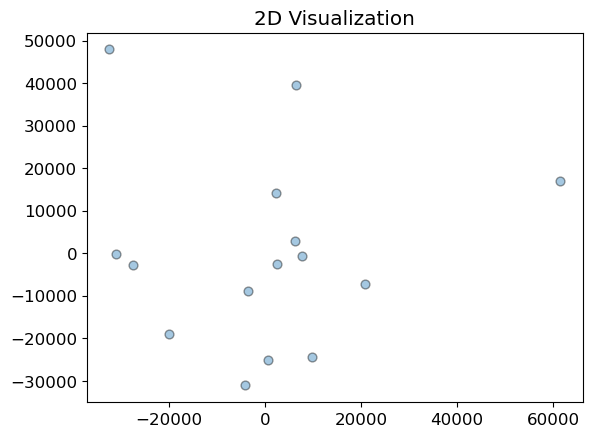



===== Ψ = DCT, k =0.1 ======

Sample 1


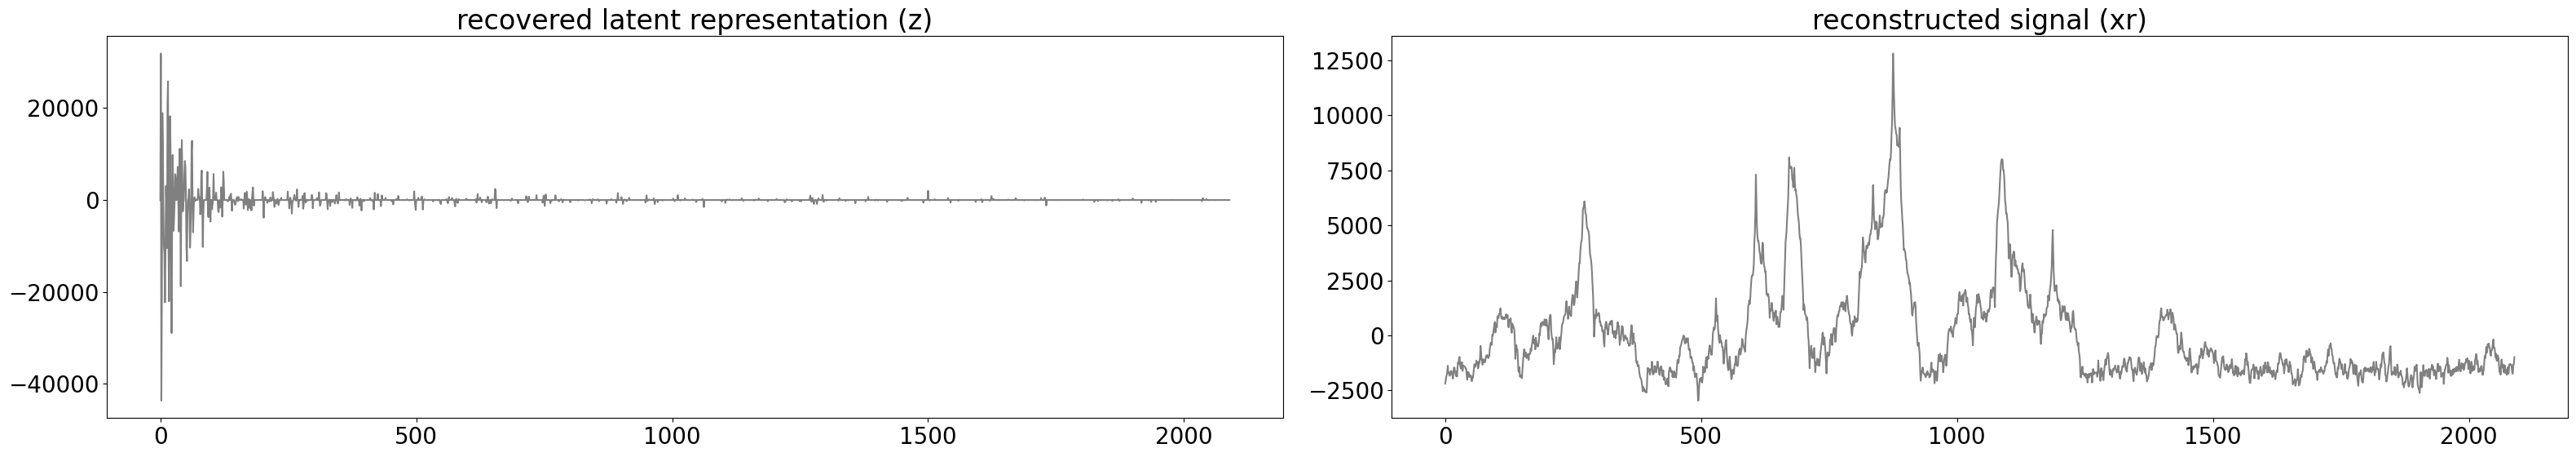

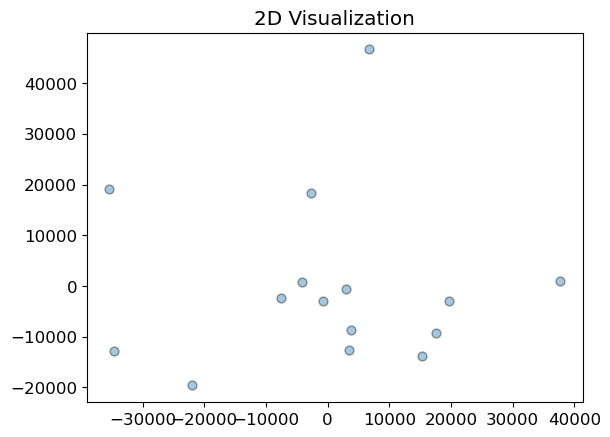



===== Ψ = DCT, k =0.5 ======

Sample 1


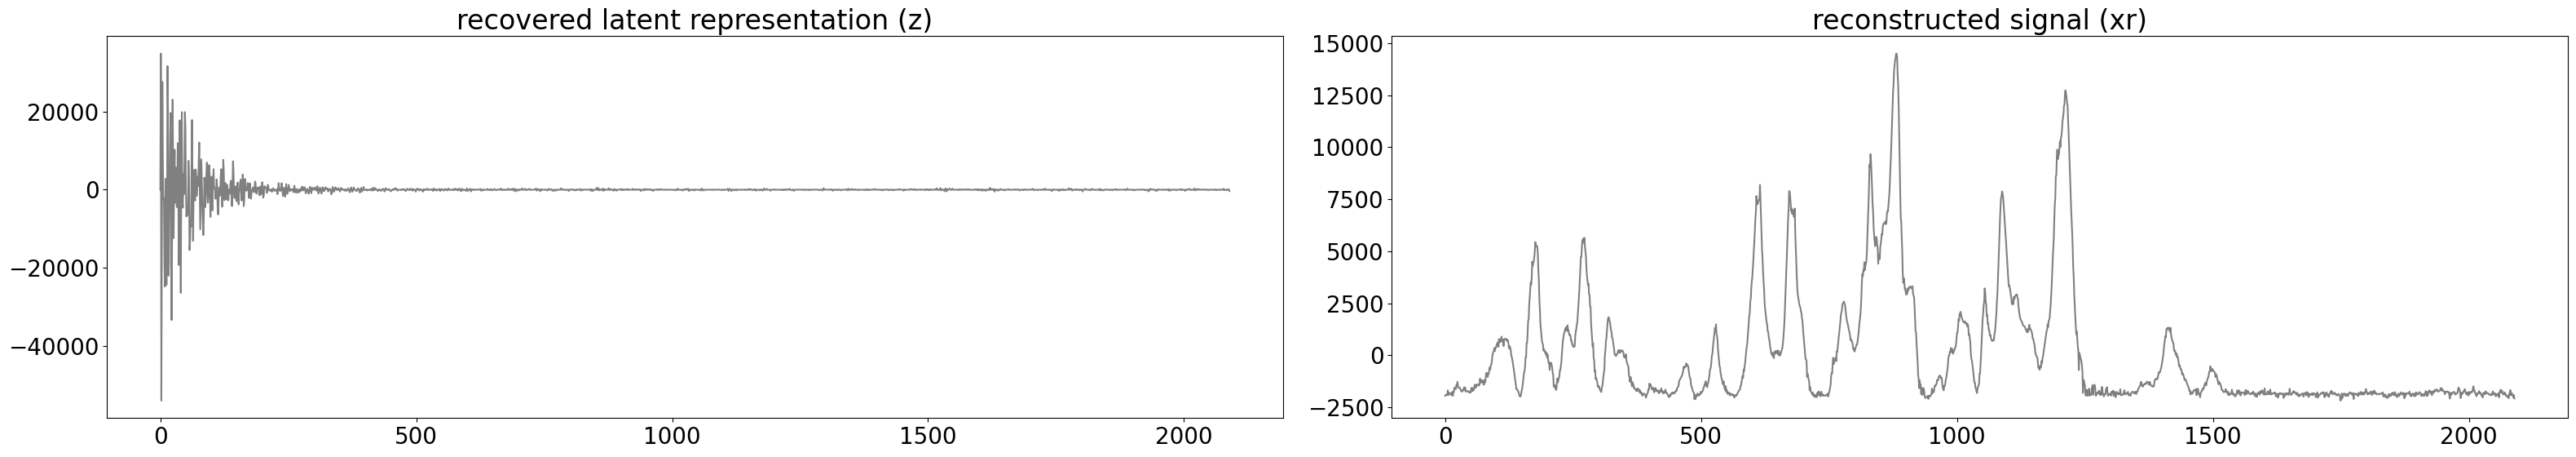

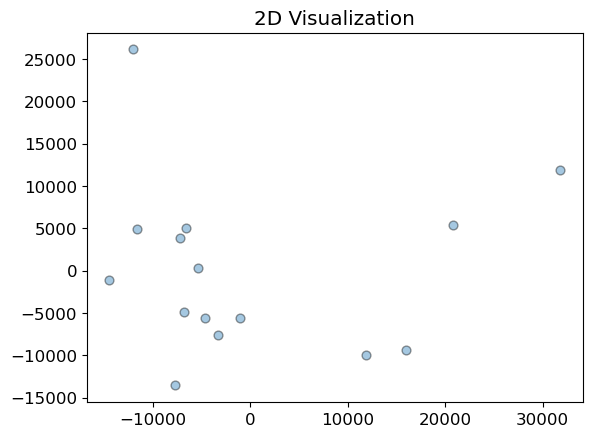

In [7]:
for t in ['IDM', 'DCT']:
    for k in [0.10, 0.50]:        
        _ = cs.Dataset_Sensing_n_Recovery (X, k = k, t = t, solver = 'LASSO', display = 'first')

Several phenomena can be observed. 1) For Ψ = IDM, z = xr. This case equals performing sampling and reconstruction directly in the original space. 2) The reconstruction result of HWT is noisier and “spikier” than DCT and DFT. 3) When k is small (e.g., 0.01, or only 1% information is sampled), the reconstruction error is significant. By increasing k, the error goes down. 4) For k >= 0.1, both DCT and DFT demonstrate decent reconstruction results, though DFT is “spikier” at certain positions than DCT. 

## Best hyper-parameters for the Raman dataset

PSI = "DFT", k = 0.3

# Security Verification

In this part, we simulate a security senario: a hacker intercepts our transmmitted signal xs. He/she tries to guess the sensing matrix and reconstruct the signal with the brute-force method.

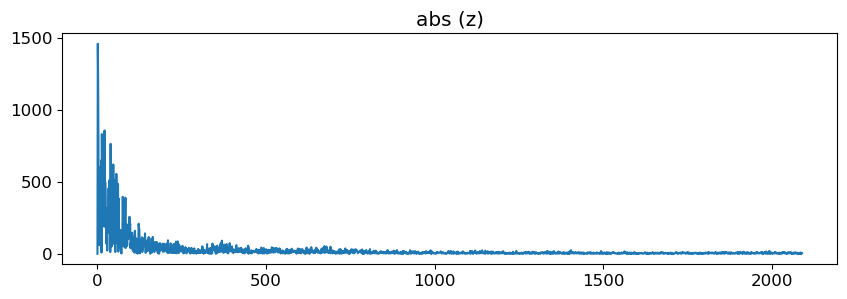

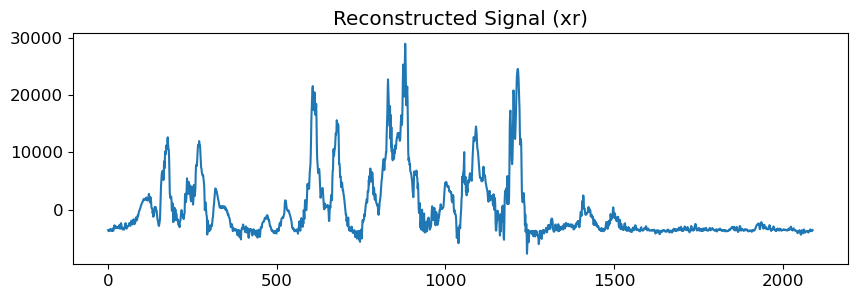

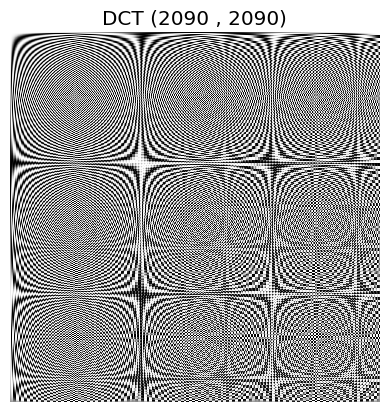

AUC =  0.993 
sparsity =  0.934


In [8]:
import cs1.basis.common
import numpy as np
from cs1 import cs

k = 0.3
t='DFT'
N = len(X[0])

xs, idx_g = cs.Sensing(X[0], k) # idx is the sensing indices. It is an eqaulivalent representation for the senging matrix.

A = cs.MeasurementMatrix (N, idx_g, t)
xr_g, _ = cs.Recovery (A, xs, t = t)

z_g = cs1.basis.common.dctmtx(N, N) @ X[0]

MAX = abs(max(z_g, key=abs))

auc = 0
for i in range(1000):
    auc += (np.abs(np.array(z_g)) <= (i+1)/1000 * MAX).sum() / len(z_g)        
auc = auc/1000

r = (np.abs(np.array(z_g)) <= 0.02 * MAX).sum() / len(z_g)  # use 0.01 MAX ABS as threshold    

print('AUC = ', round(auc, 3), '\nsparsity = ', round(r, 3))

idx is the sensing indices. It is an eqaulivalent representation for the senging matrix.   
During the data transmission, idx is not transfered (will be generated by the internal TVSMG on both sides).   

With the intercepted signal xs, the hacker try to guess the sensing matrix (idx).  

In [9]:
import cs1.security.tvsm
cs1.security.tvsm.brute_force_total_guesses(N, len(xs), verbose = True)

N =  2090 , K =  627
A(N,K) in log10 =  2036.1280922561273
Total years needed to iterate all combinations (in log10) =  2028.6289882890421


2036.1280922561273

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:54<00:00,  4.27it/s]

Best AUC =  0.86 
sparsity =  0.088


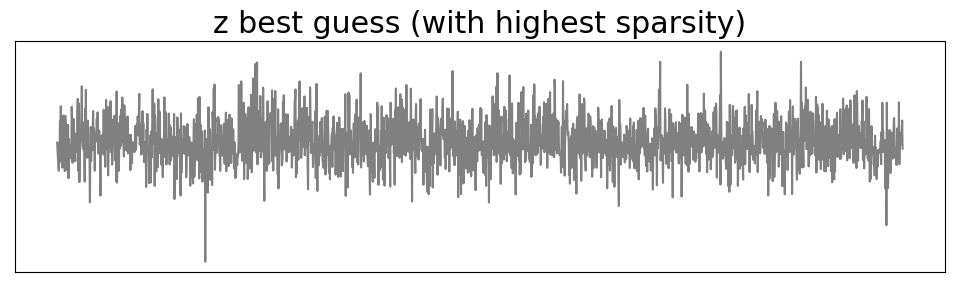

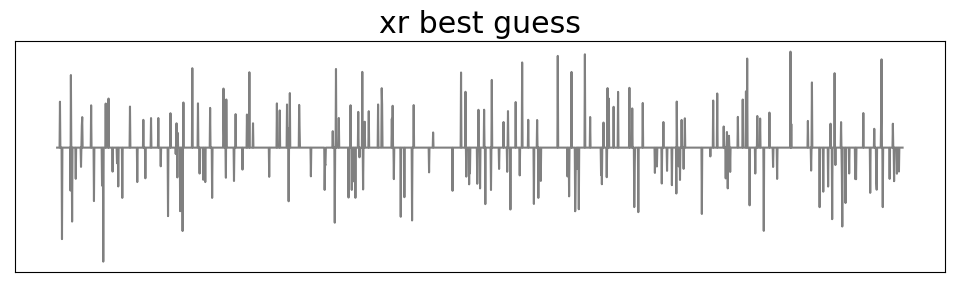

(array([ -145.57148687, -1405.63968004, -2667.42704223, ...,
         1799.74622902,  3283.22377044, -1113.30340779]),
 array([0., 0., 0., ..., 0., 0., 0.]))

In [10]:
cs1.security.tvsm.brute_force_guess(xs, N, t = 'DCT', solver = 'OMP', ITER = 1000)

Each iteration costs about 5 second on the current workstation. CPU: 2.2G × 6 Cores, Memory: 24 GB

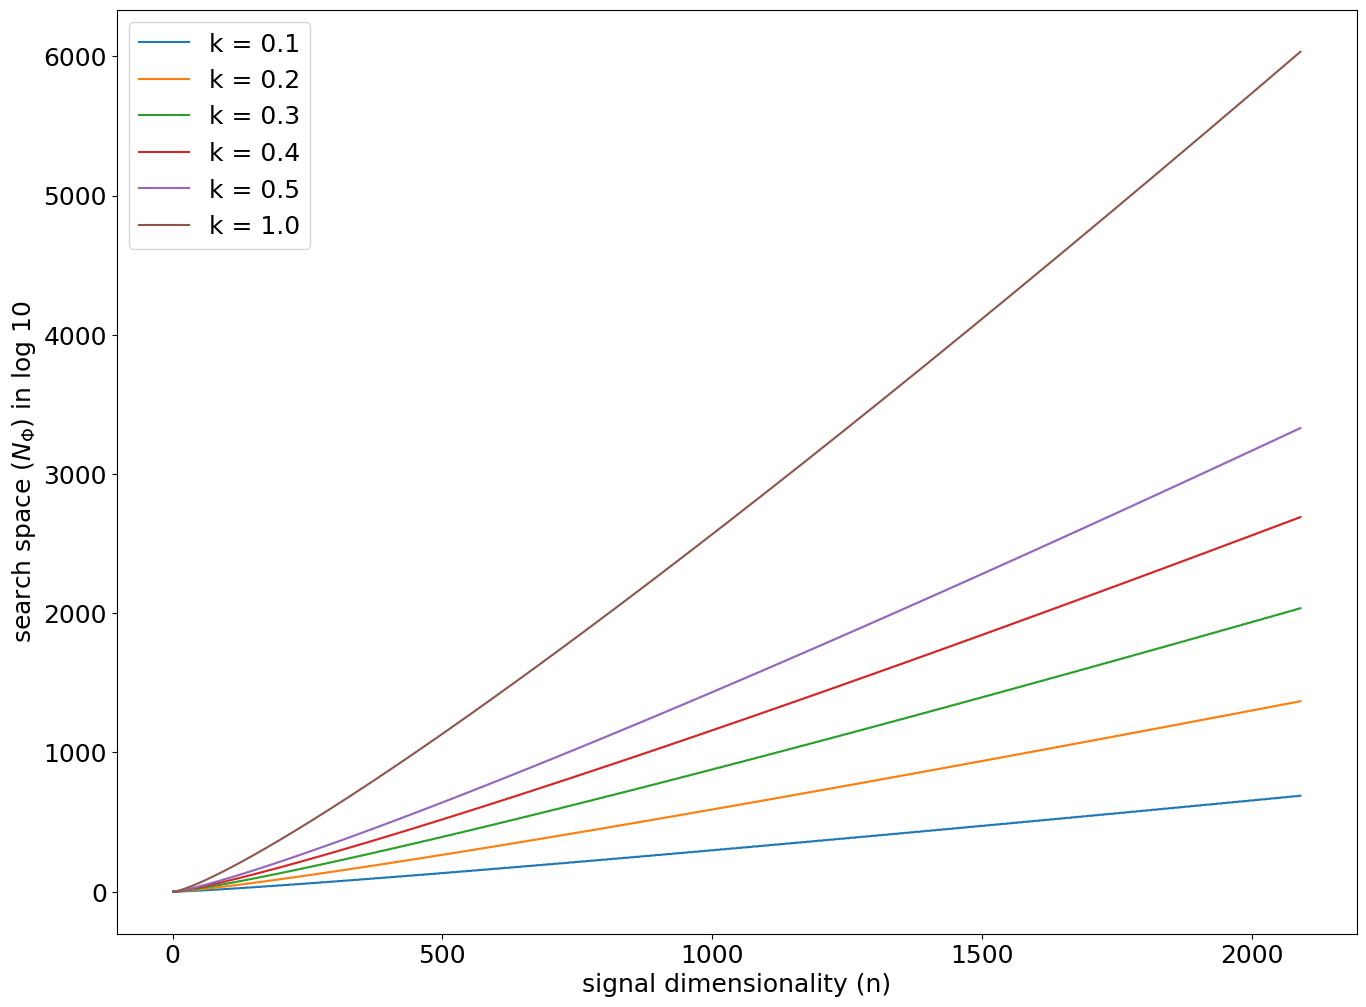

In [11]:
import cs1.security.tvsm
cs1.security.tvsm.brute_force_guess_plot(N)

# Appendix

## 1. Github (http://github.com/zhangys11/cs1)

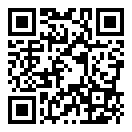

## 2. A CS web demo (http://qsi.zhangys.org.cn/CS)

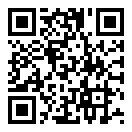

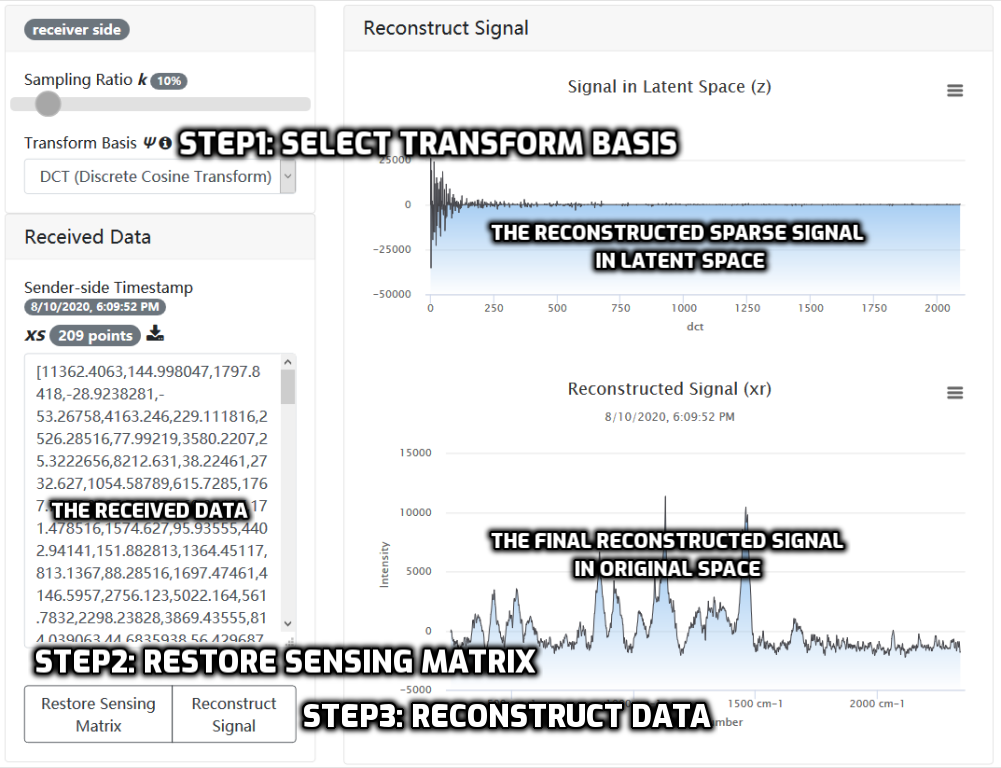

# 3.  Demostrate how the sampling ratio k and signal pre-treaments influence CS reconstruction quality


-------------
The following are dynamic properties of each PSI:


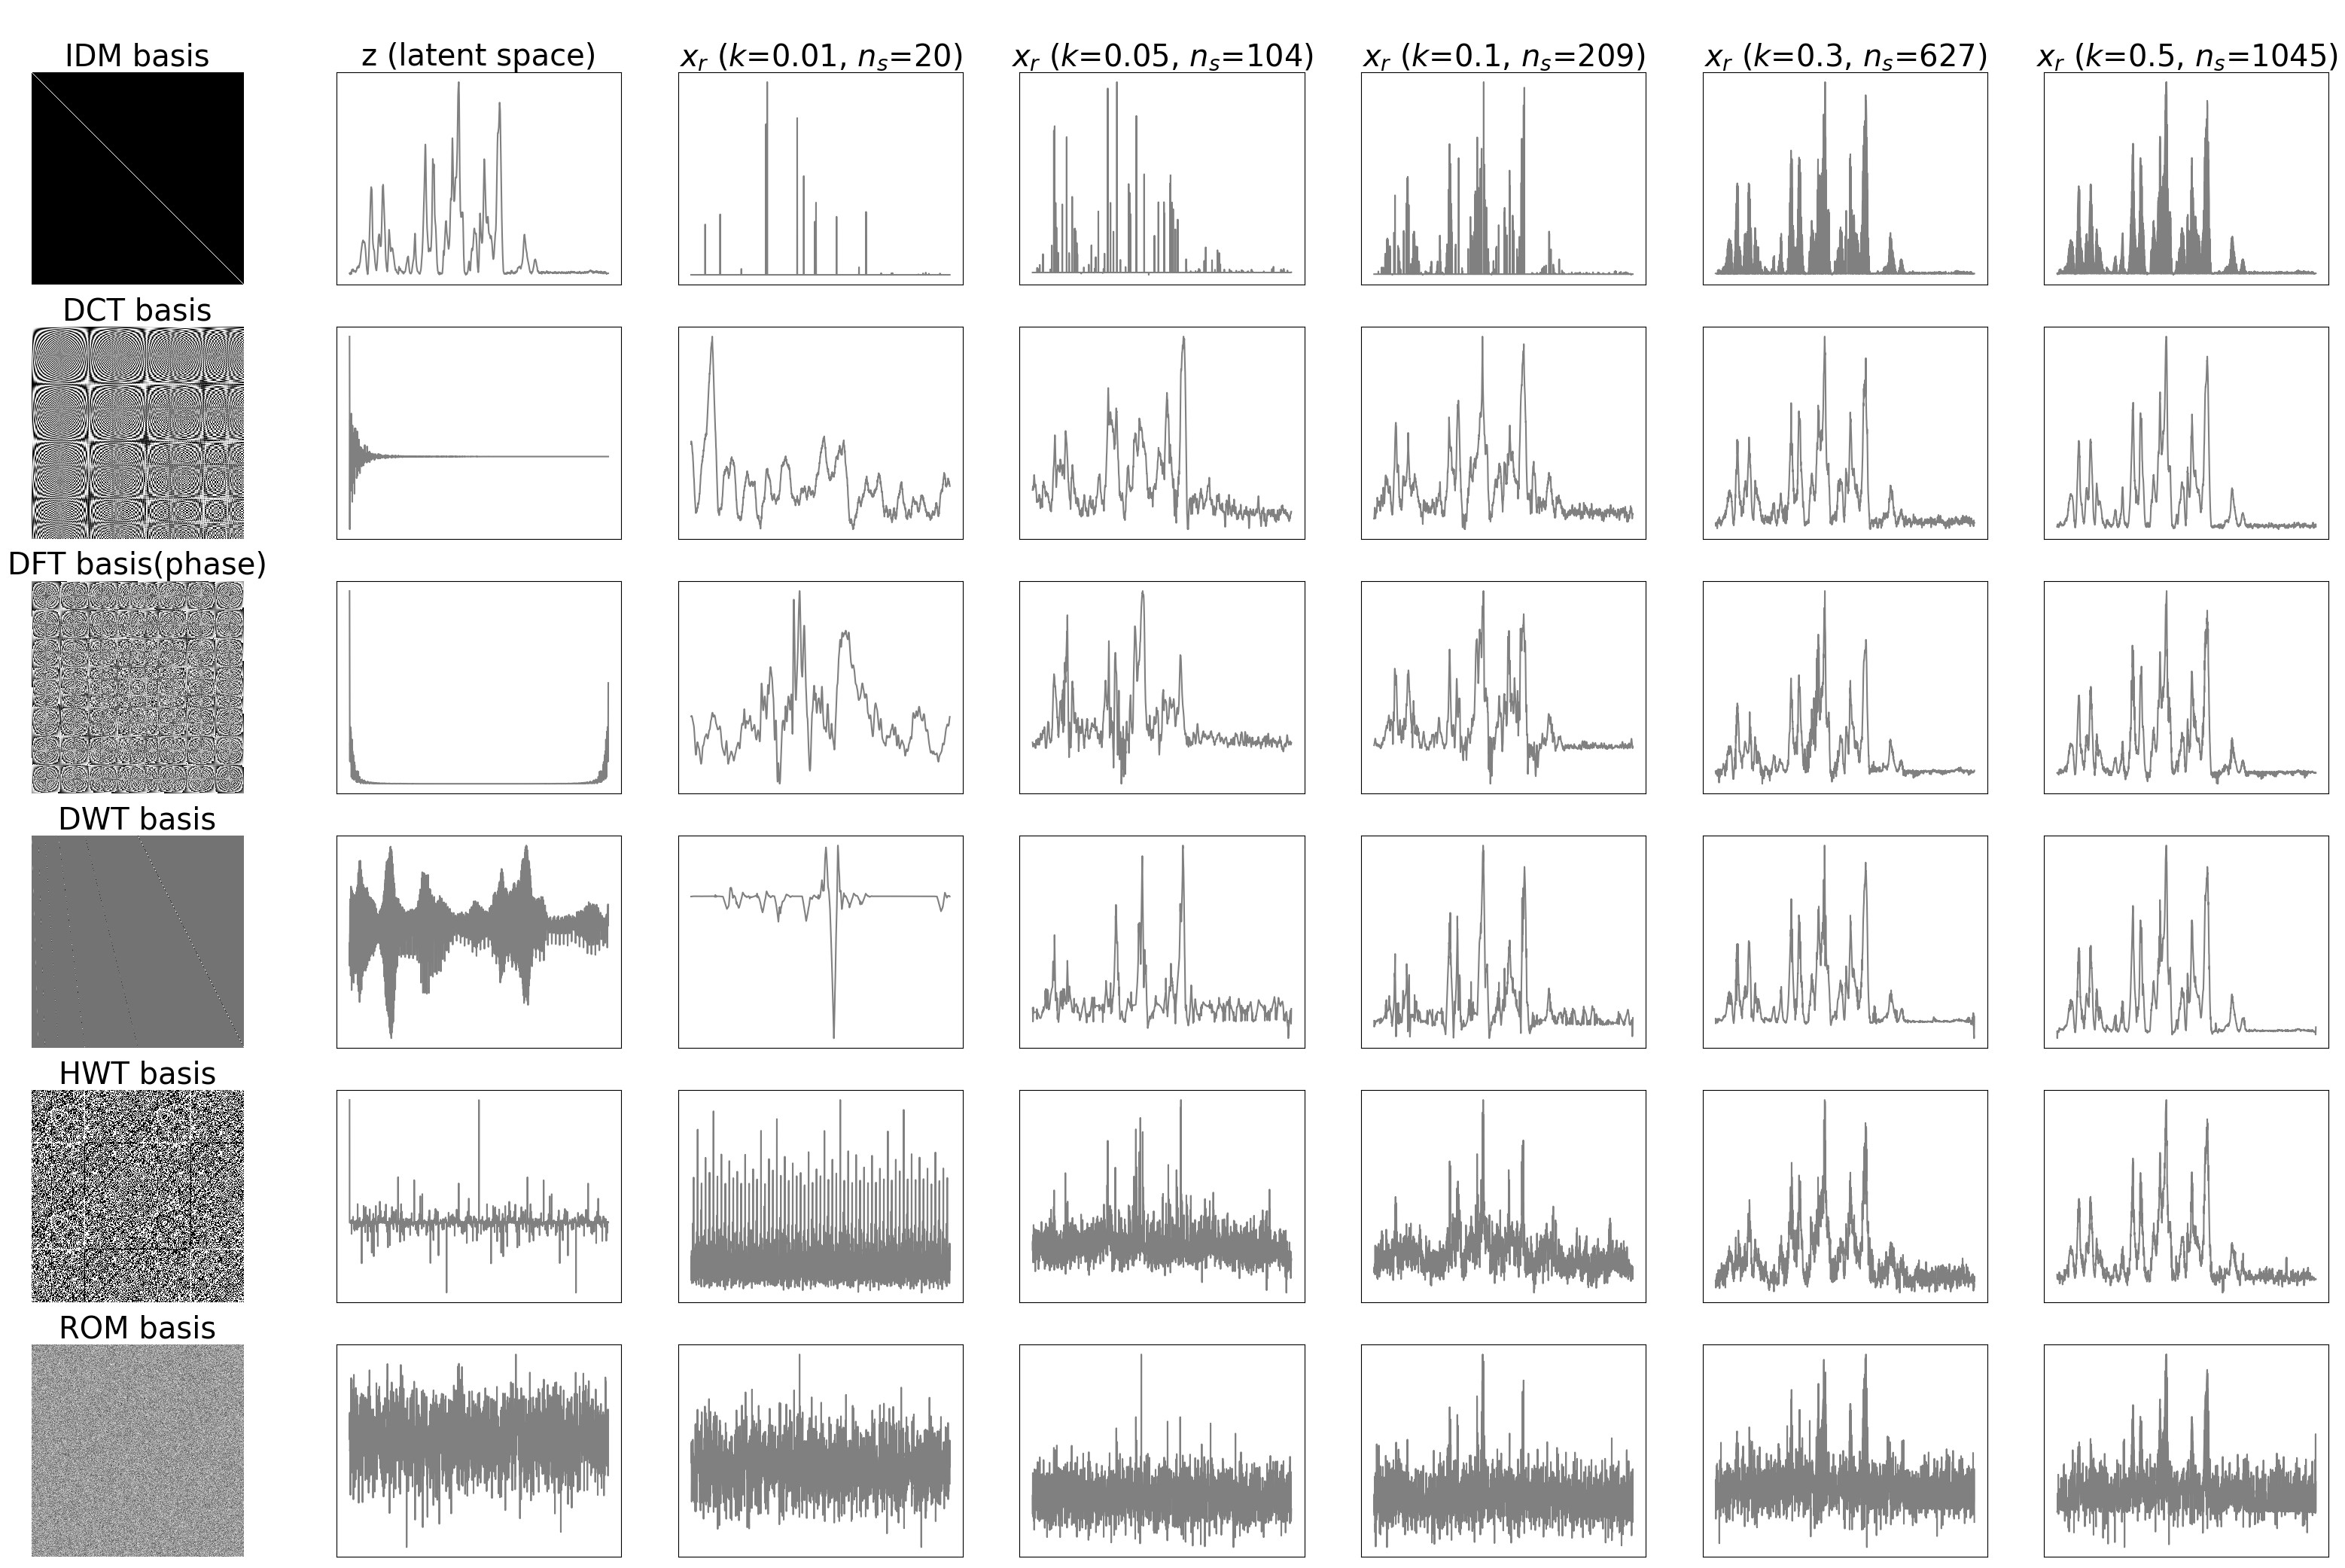

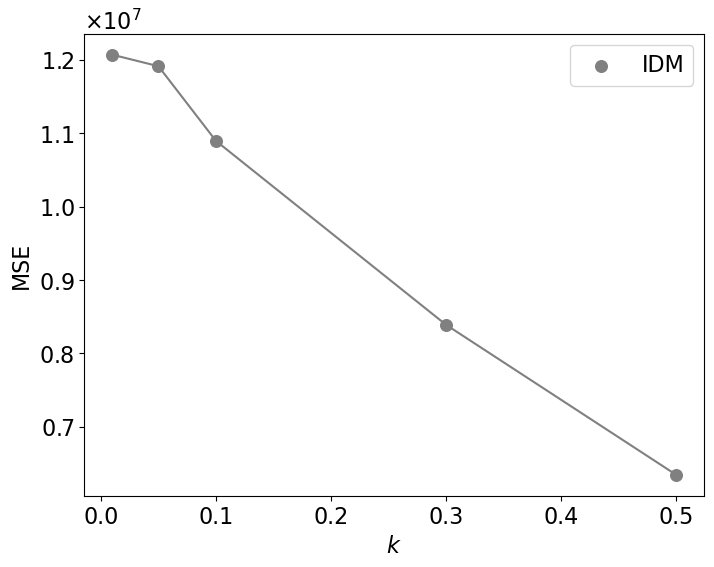

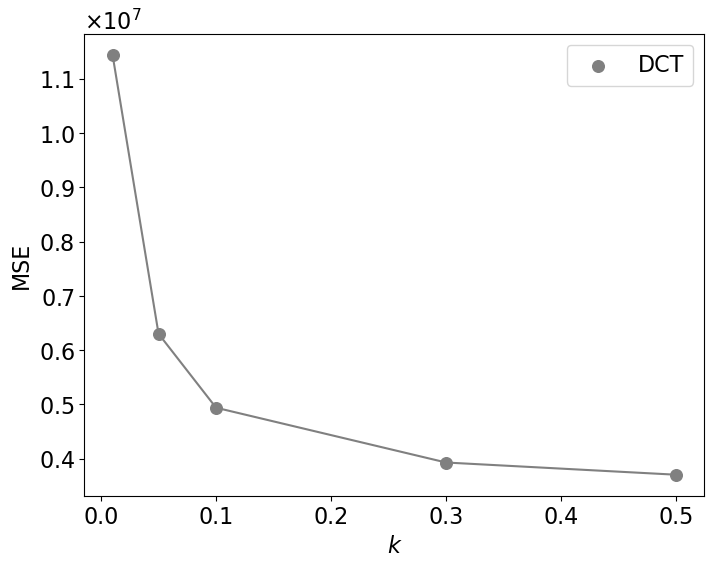

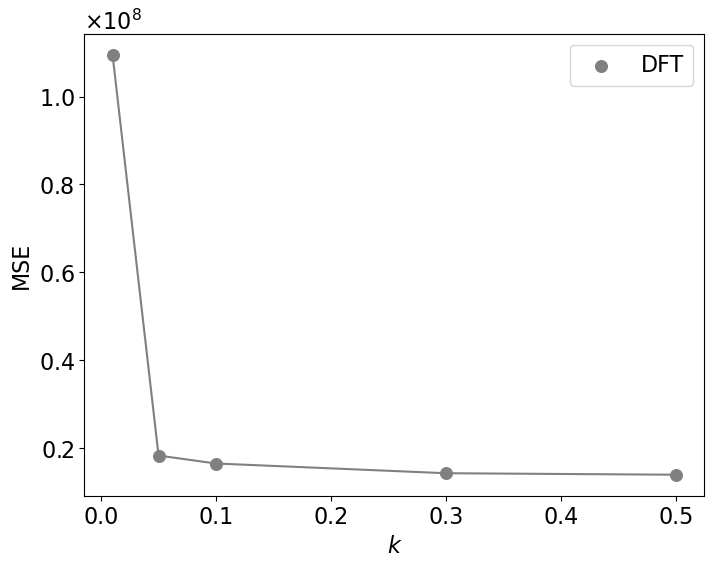

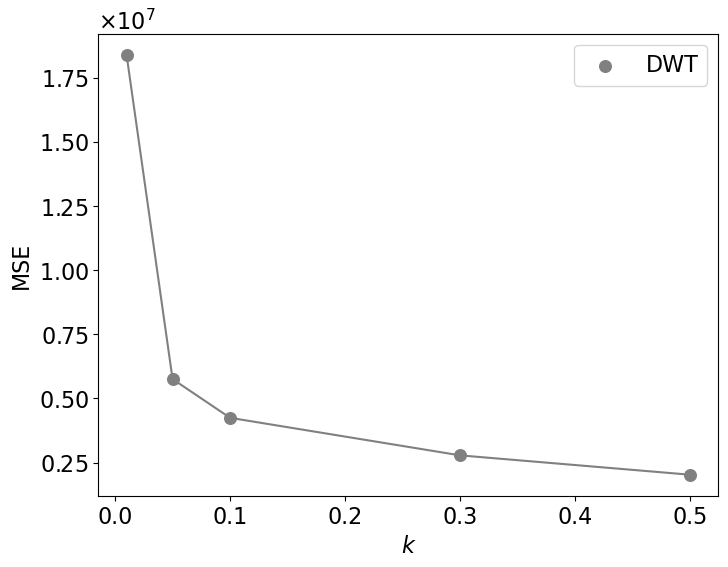

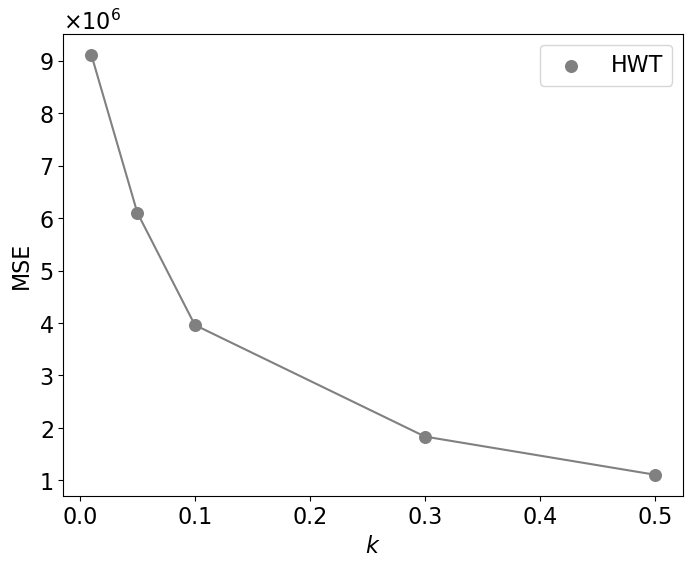

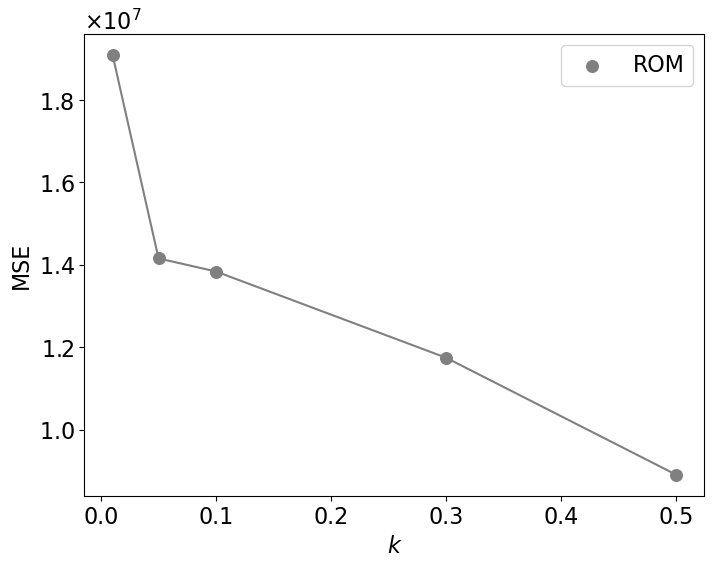

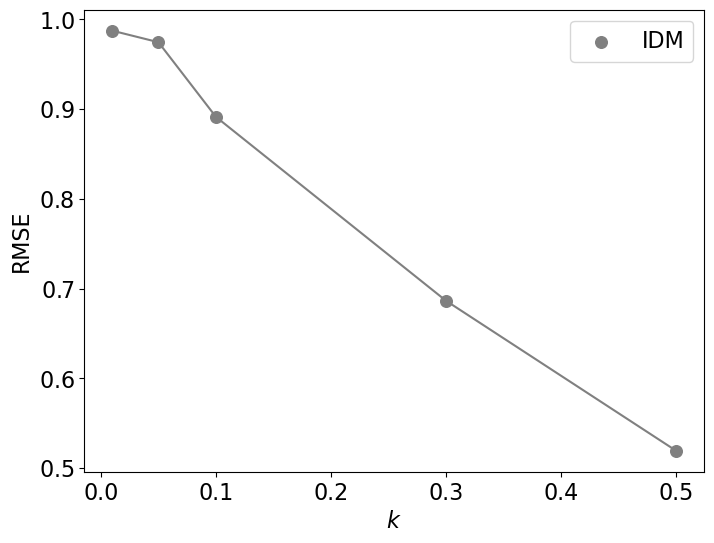

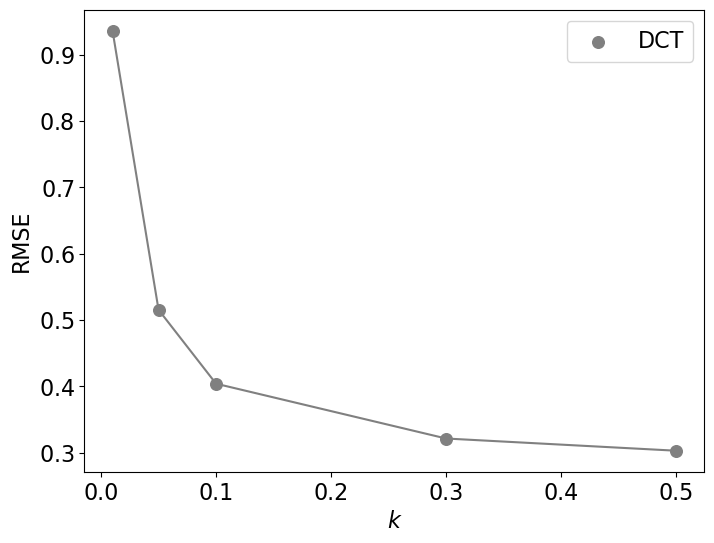

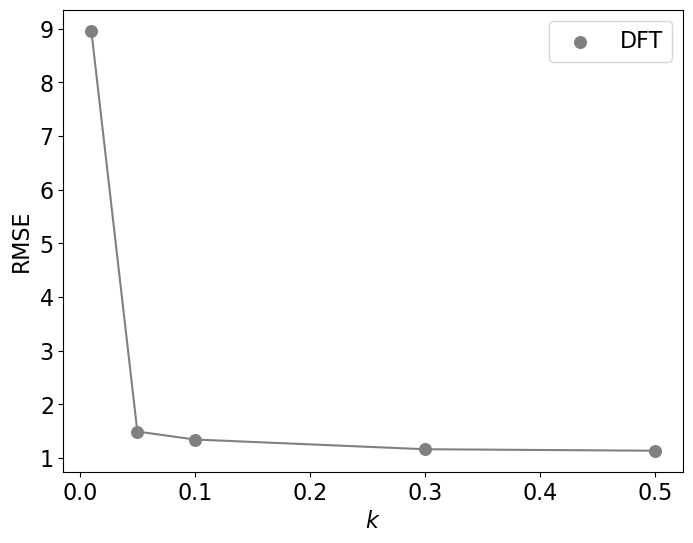

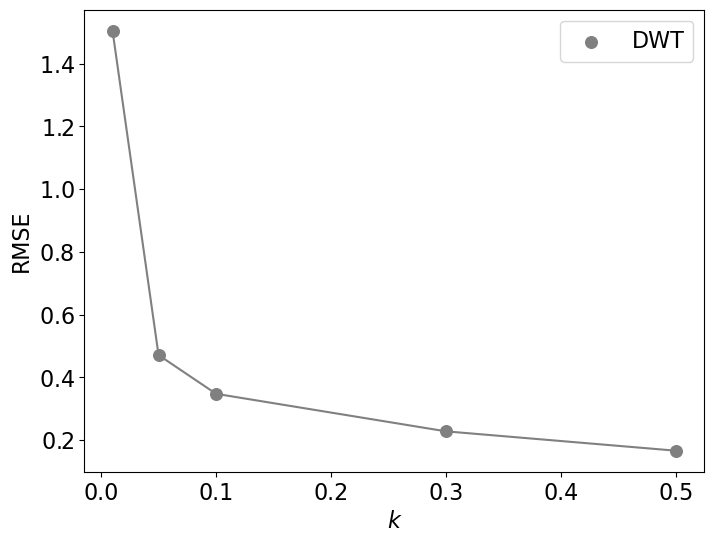

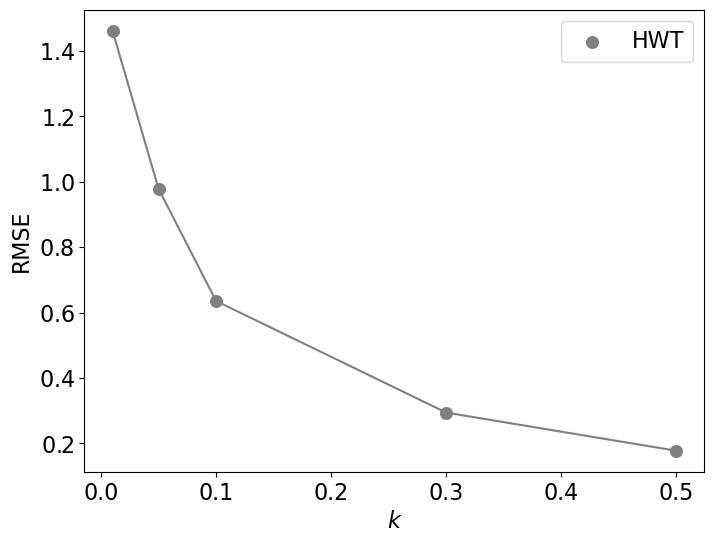

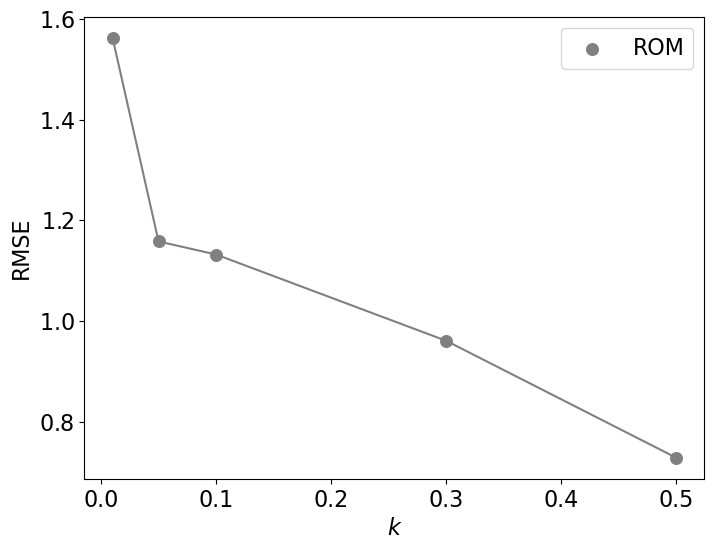

In [19]:
from cs1 import cs

mses, rmses = cs.GridSearch_Sensing_n_Recovery(X[0], PSIs, ks = [0.01, 0.05, 0.1, 0.3, 0.5]) # the result may vary each time due to random sampling

After a specific pre-treatment or pre-processing, the original signal’s statistical and sparsity property can be changed (can be better or worse), which will influence the effectiveness of CS and the reconstruction quality. 
As suggested by the reviewer, we conducted the following pre-treatments: first and second derivatives, smooth filtering and scatter correction.
For each case, we performed a CS sampling and reconstructed on the pre-processed signal. The results are as follows.

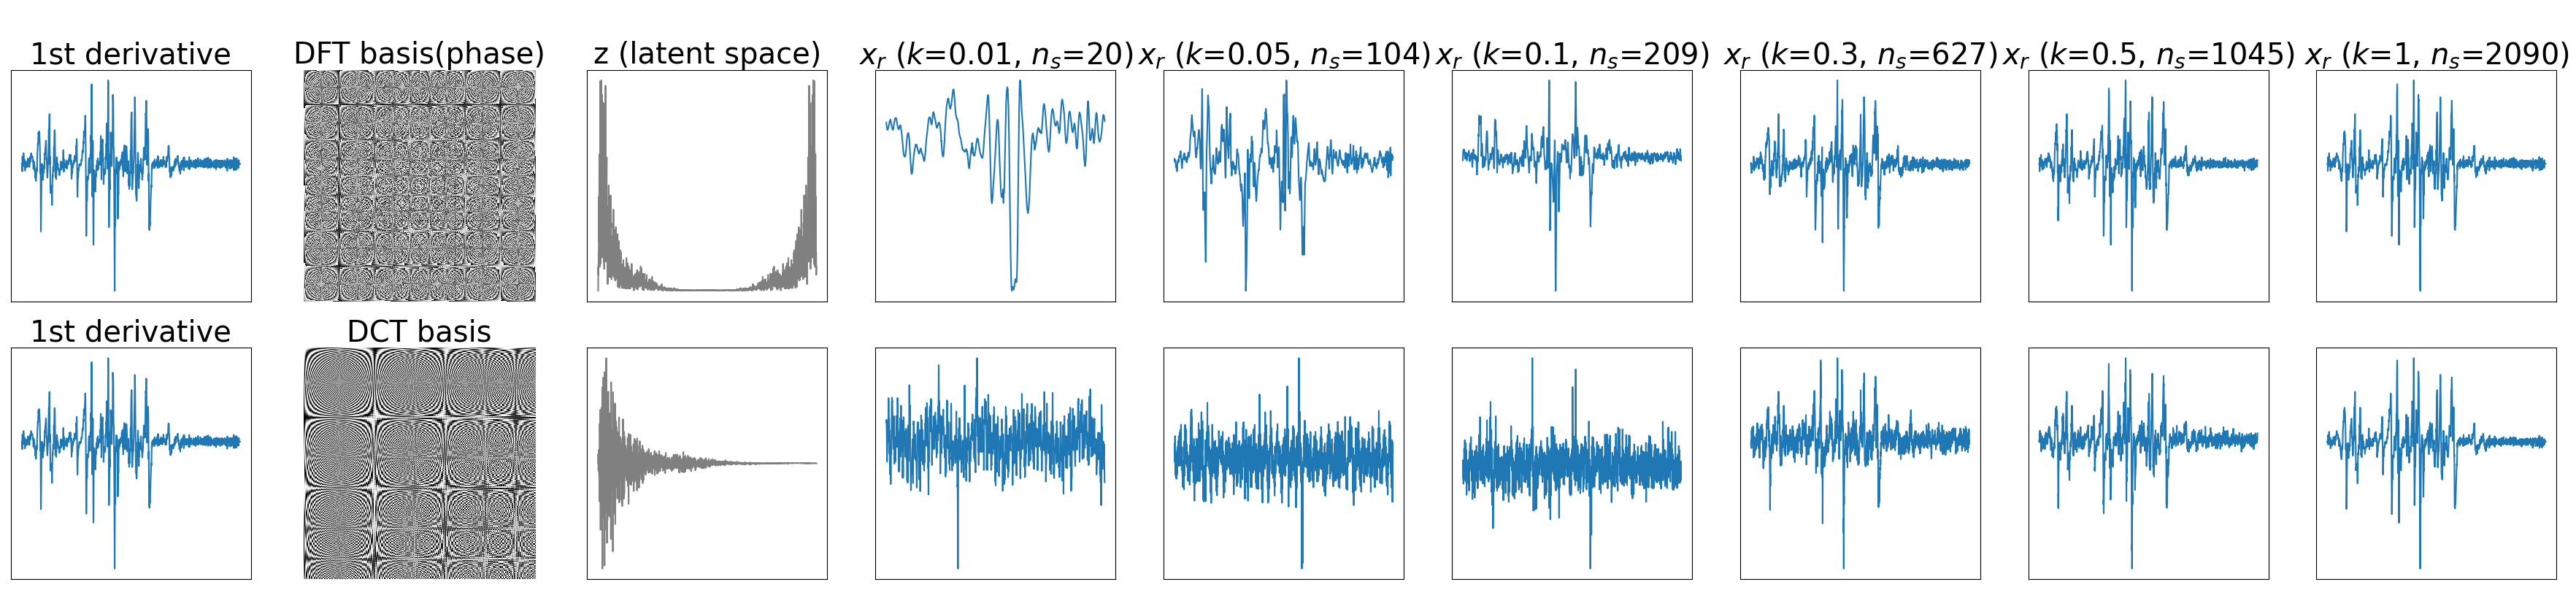

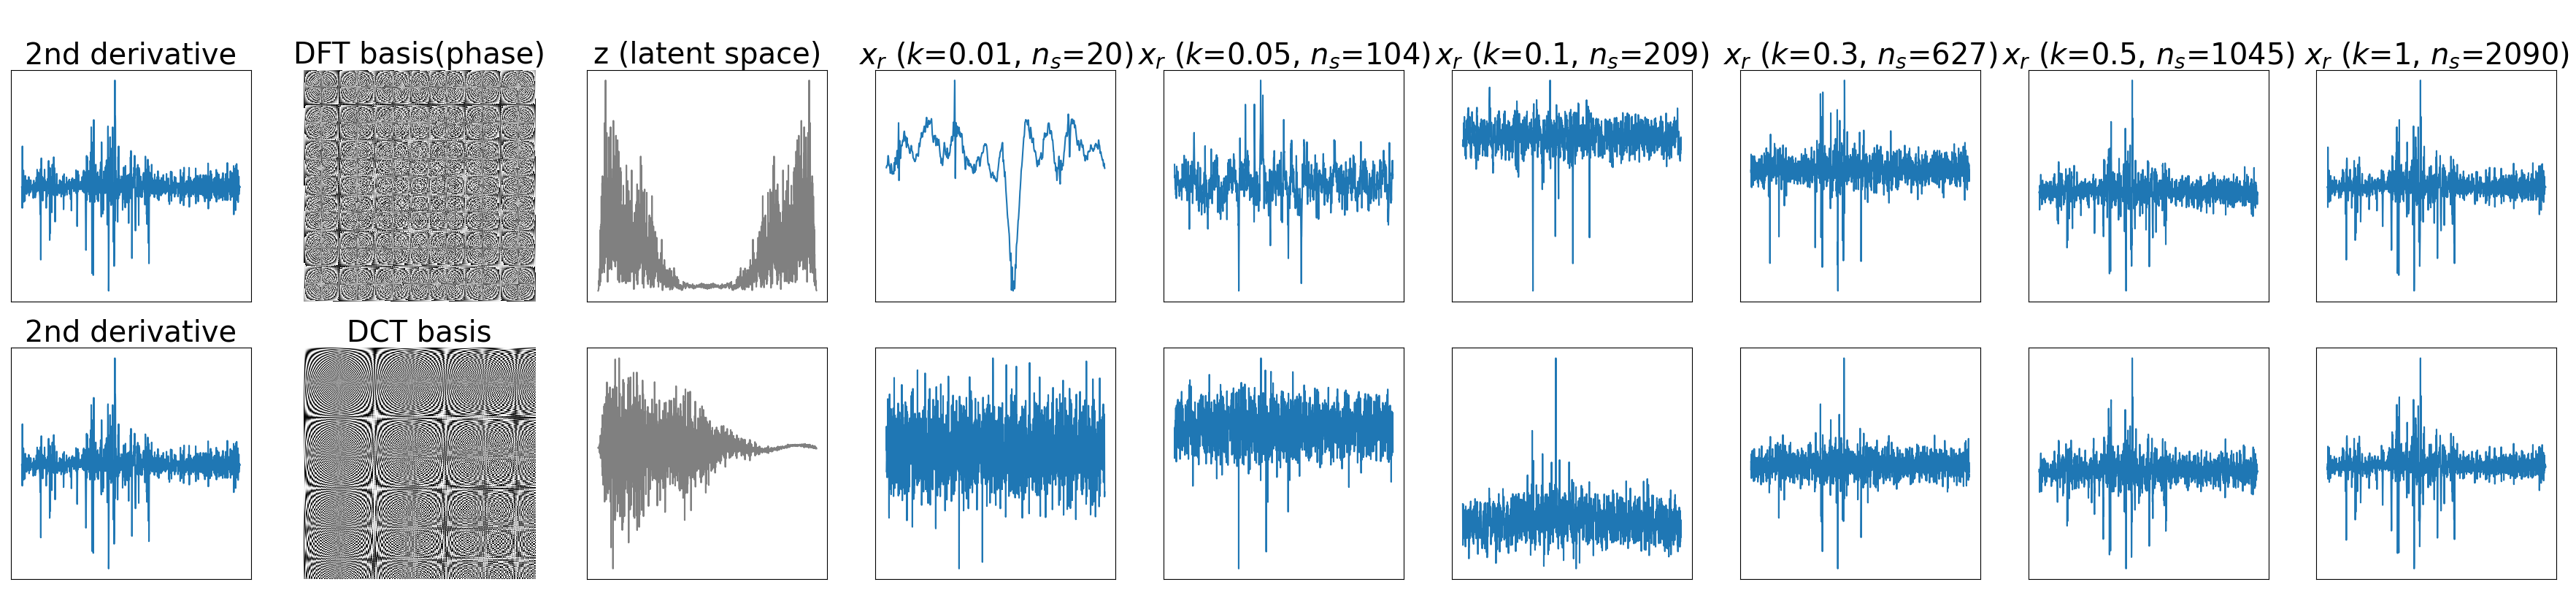

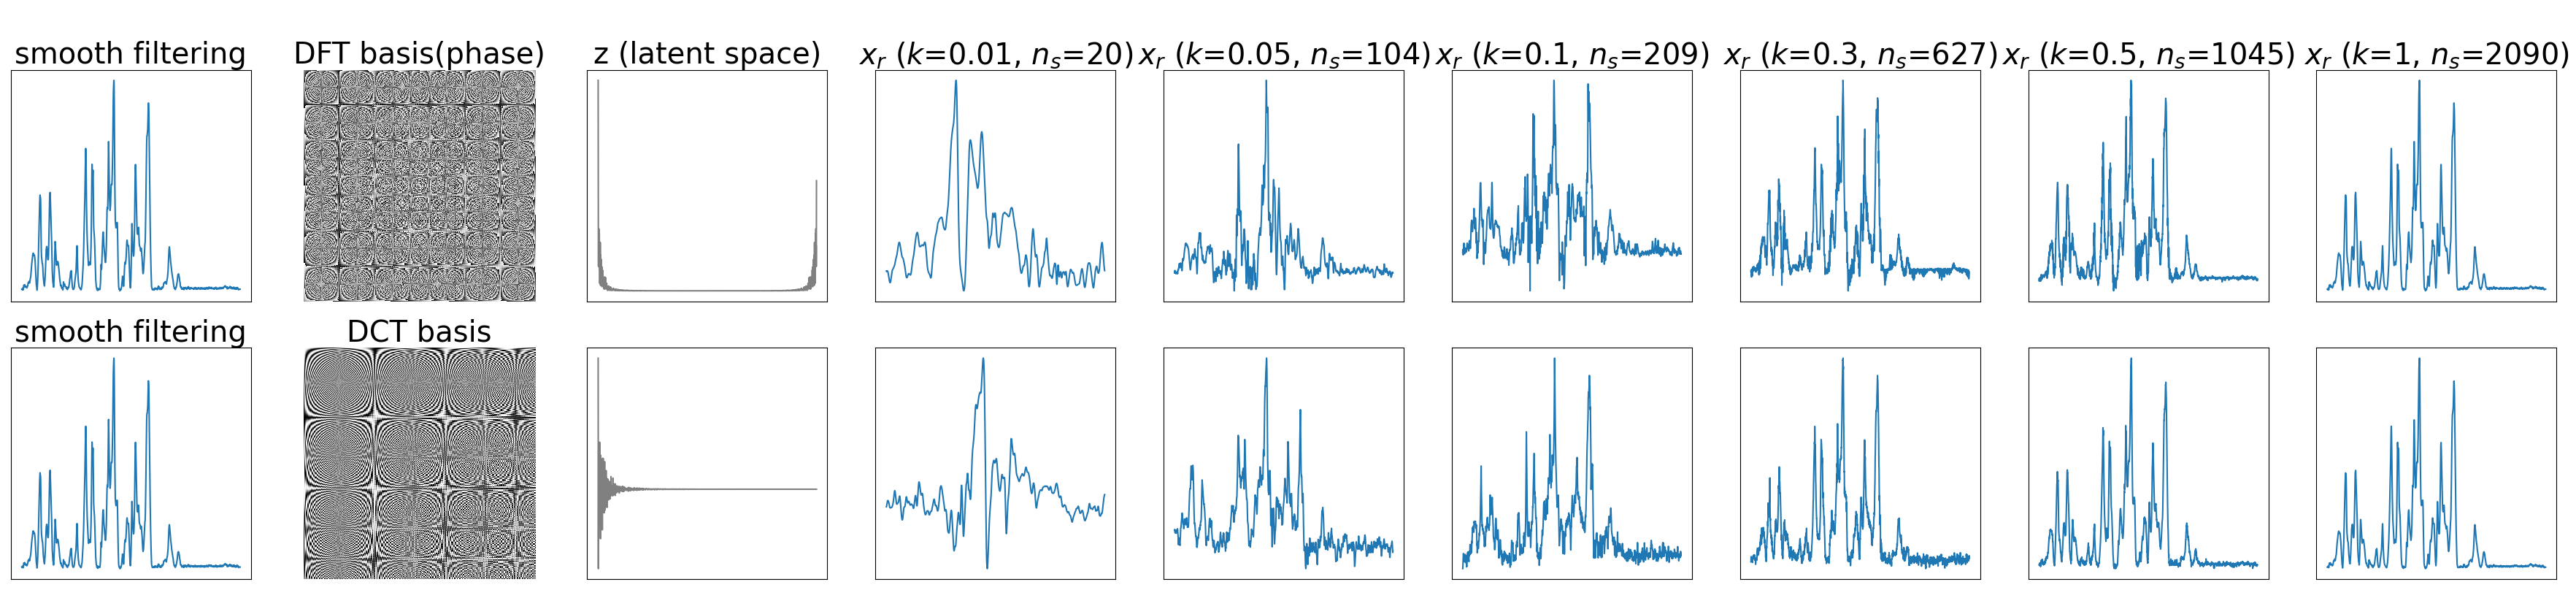

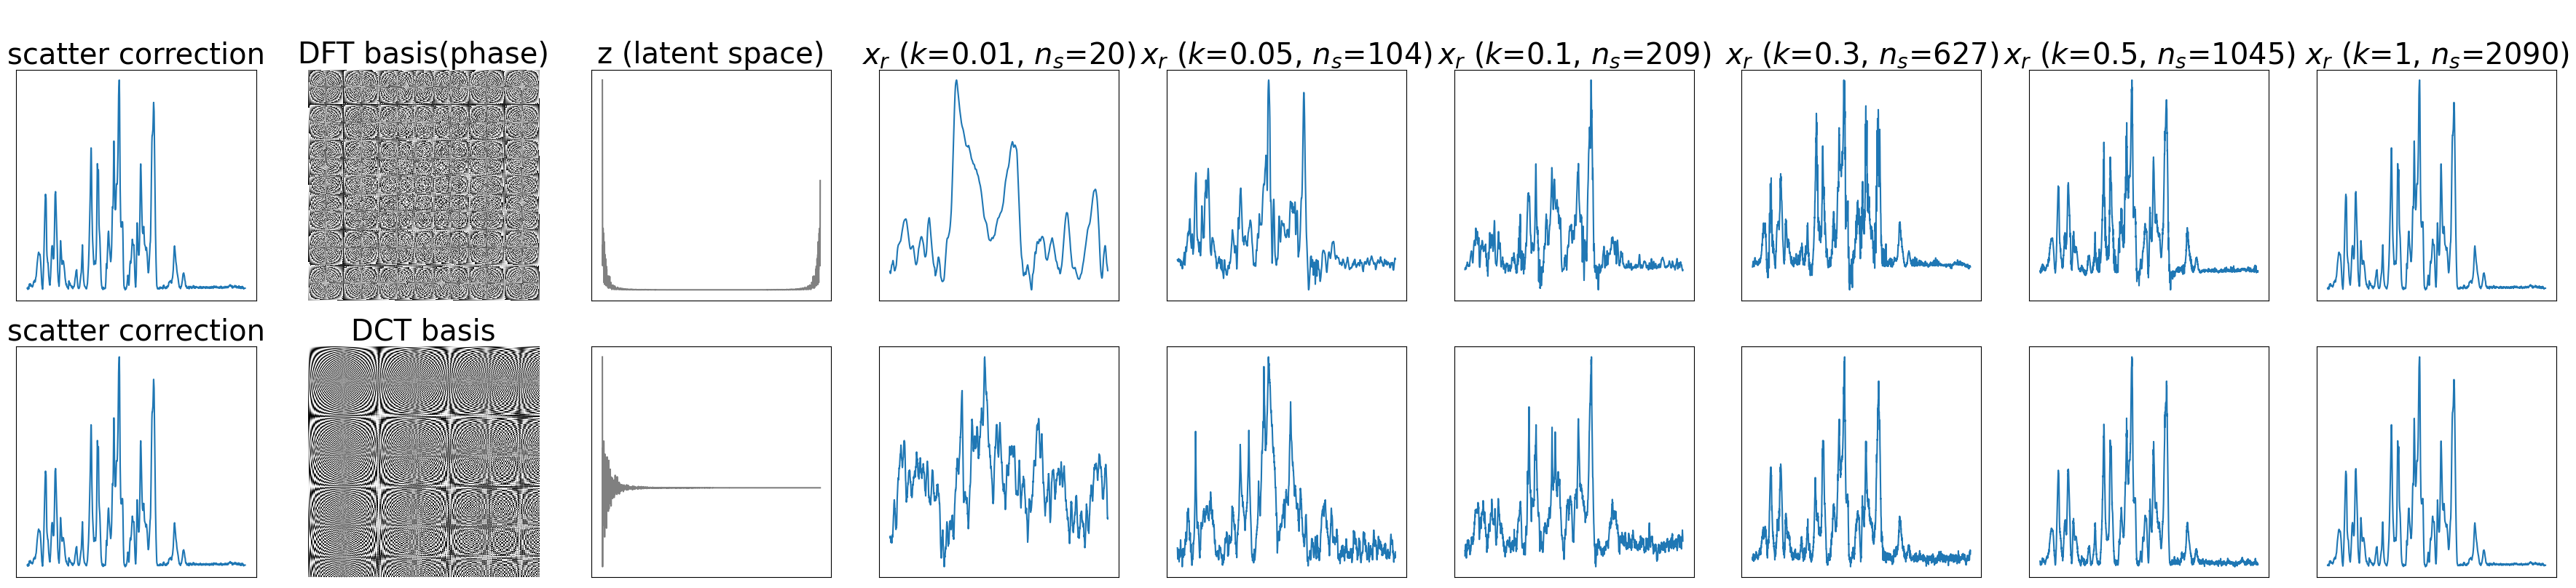

In [44]:
from scipy import signal
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from cs1 import cs

def preprocessed_singal_sensing_n_recovery(x, X, PSIs, ks = [0.01, 0.05,0.1,0.3,0.5,1]):
    
    '''
    Provide a complete pipeline for signal sensing and recovery with a speicfic PSI. 
    Parameters
    ----------
    k : sampling ratio/percentage. 
        In normal cases (k<1), Az = xs has more unknowns than equations. For the extreme case of k = 1, CS sampling is degraded to a random shuffling. The linear system 'Az = xs' will have equal unknowns and equations, and there is only one solution. The reconstructed xr will be identical to the original x.
    '''
    def D1(x):
        return np.array([0] + list(np.diff(x)))
    
    # Second derivatives
    def D2(x):        
        return D1(D1(x))


    # Scatter correction
    def MSC(X):
        '''
        X : a batch of samples for training, not a single sample.
        
        Sample
        ------
        plt.plot(MSC(X)[0]) # display the 1st sample after MSC
        '''
        n, p = X.shape
        Xmsc = np.ones((n, p))

        # mu = x.mean()

        for j in range(n):
            mu = np.mean(X, axis=0)

        for i in range(n):
            y = X[i, :]
            l = LinearRegression()
            l.fit(mu.reshape(-1, 1), y.reshape(-1, 1))
            k = l.coef_
            b = l.intercept_
            Xmsc[i, :] = (y - b) / k

        return Xmsc
    
    
    x1=D1(x)
    x2=D2(x)
    x3=signal.savgol_filter(x, window_length=5, polyorder=3)    
    x4=MSC(X)[0]
        
    for x, method in zip([x1,x2,x3,x4],['1st derivative','2nd derivative','smooth filtering','scatter correction']):
        
        # print(method)        
    
        plt.figure(figsize=(15 + len(ks)*5, len(PSIs)*7))
        rows = len(PSIs) + 1
        matplotlib.rcParams.update({'font.size': 24})    
        COLS = 3 + len(ks)
        MSES = []
        RMSES = []

        for idx, key in enumerate(PSIs):

            PSI = PSIs[key]
        
            # padded version
            xe = np.copy(x)
        
            # pad x with zero if necessary
            if (len(x) < len(PSI)): # the HWT case
                xe = np.zeros(len(PSI))
                xe[:len(x)] = x     
            if len(xe) % 2 == 1:
                xe = xe[:-1] # xe = np.append(xe, 0) # make even length, as required by some transform, e.g., DCT
                PSI = PSI[:-1,:-1] # align with xe
        
            psi_name = key
        
            z = PSI @ xe
            
            MAX = np.max(np.abs(z)) # abs(max(z, key=abs))
            thresholds = np.array(range(100)) / 50000
        
            rs =[]
            for threshold in thresholds:
                rs.append((np.abs(np.array(z)) <= threshold * MAX).sum() / len(z))
            
            auc = 0
            for i in range(1000):
                auc += (np.abs(np.array(z)) <= (i+1)/1000 * MAX).sum() / len(z)        
            auc = auc/1000
        
            r = (np.abs(np.array(z)) <= 0.001 * MAX).sum() / len(z)  #   # use 0.001 MAX ABS as threshold # sys.float_info.epsilon
        
        
            ########## plot ###########    
    
            plt.subplot(rows,COLS,COLS*idx+1)  
            plt.title(method)
            plt.plot(x)
            plt.xticks([])
            plt.yticks([])  
            
            
            plt.subplot(rows,COLS,COLS*idx+2)    
            if PSI.dtype == 'complex': # DFT
                plt.title('\n'+psi_name + ' basis(phase)')
                plt.imshow(np.angle(PSI), interpolation='nearest', cmap=cm.Greys_r)
            else:
                plt.title('\n'+psi_name + ' basis')
                plt.imshow(PSI, interpolation='nearest', cmap=cm.Greys_r)
            plt.axis('off')
            
            
            plt.subplot(rows,COLS,COLS*idx+3)

            if np.any(np.iscomplex(z)):
                plt.plot(np.abs(z), color='gray')
            else:
                plt.plot(z, color = 'gray')
                
            if idx == 0:
                plt.title('z (latent space)') # '\n'+psi_name + 

            plt.xticks([])
            plt.yticks([])
            # plt.axis('off')
        
            mses = []
            rmses = []
        
            for kidx, k in enumerate(ks):
        
                ########## sensing #############

                # either works fine
                if True:
                    PHI, OMEGA = cs.GetSensingMatrix(len(xe), k)            
                    xs = PHI @ xe
                    pidx = np.argmax(PHI, axis = 1)
                else:
                    xs, pidx = Sensing(xe, k)
                    PHI = np.zeros((len(pidx), len(xe)))
                    for i,j in enumerate(pidx):
                        PHI[i, j] = 1

                ####### reconstruction ##########
            
                A = cs.MeasurementMatrix(len(xe), pidx, psi_name)
                W = None
                if (psi_name == 'HWT' or psi_name == 'DWT' or psi_name == 'ROM' or \
                    psi_name == 'EBP' or psi_name == 'LDA'):
                    W = PSI
                    A = PHI @ W  

                else:
                    A = cs.MeasurementMatrix(len(xe), pidx, psi_name)
                    W = None

                z, xr = cs.Recovery (A, xs, psi_name, display = False, PSI = W, ) # lower k needs bigger L1. k 0.1 - L1 0.1, k 0.01, L1 - 10
            
                mse, _, rmse = cs.calculate_recon_error(xe.reshape(1, -1), xr.reshape(1, -1)) #(np.matrix(xe), np.matrix(xr))        
                mses.append(mse)
                rmses.append(rmse)
            
                plt.subplot(rows,COLS,COLS*idx+3+1+kidx)
                plt.plot(xr[:len(x)]) #, label = 'RMSE ' + str( round(rmse, 3) ), color='gray') # cut the first n points, as in HWT, xr is padded.
                if idx == 0:
                    plt.title('$x_r$ ($k$=' + str(round(k, 2)) + ', $n_s$=' + str(len(xs)) + ')')
                plt.xticks([])
                plt.yticks([])                
                # plt.legend()
            
            MSES.append(mses)
            RMSES.append(rmses)
            
        plt.show()
        
    return MSES, RMSES

# perform DFT and DCT on the preprocessed signals

newPSIs = {}
for key in ['DFT','DCT']: 
    newPSIs[key] = PSIs[key]
_ = preprocessed_singal_sensing_n_recovery(X[0], X, newPSIs , ks = [0.01, 0.05,0.1,0.3,0.5,1])

It can be seen that the reconstruction quality of the first and second derivatives is worse than the original, while smooth filtering and scattering correction becomes better. This is also reflected in their latent representation’s sparsity (the 2nd column). The 1st and 2nd -order derivatives are not sparse in the latent space, causing the CS reconstruction become worse. We have also added this point in the discussion section. 

In summary, pre-processing can have either positive or negative effect on the entire CS workflow.